In [1]:
import os; os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from urbanstats.games.quiz_analysis import get_full_statistics, questions

In [4]:
result = get_full_statistics(after_problem=41, debug=False)
num_users_by_problem = result.groupby("problem").count().user_id
means = result[["problem", "score", *questions]].groupby("problem").mean()

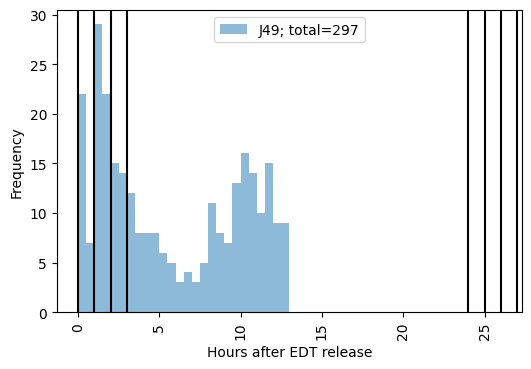

In [5]:
plt.figure(dpi=100)
for time in range(49, 1 + result.problem.max()):
    offs = result[result.problem == time].offset
    bin_sides = offs // 0.5 * 0.5
    bins = np.arange(bin_sides.min(), bin_sides.max() + 0.5, 0.5)
    plt.hist(offs, bins=bins, alpha=0.5, label=f"J{time}; total={offs.shape[0]}")
plt.xticks(rotation=90)
plt.xlabel("Hours after EDT release")
plt.ylabel("Frequency")
for h in 0, 1, 2, 3, 24, 25, 26, 27:
    plt.axvline(h, color="black")
plt.legend()
plt.show()

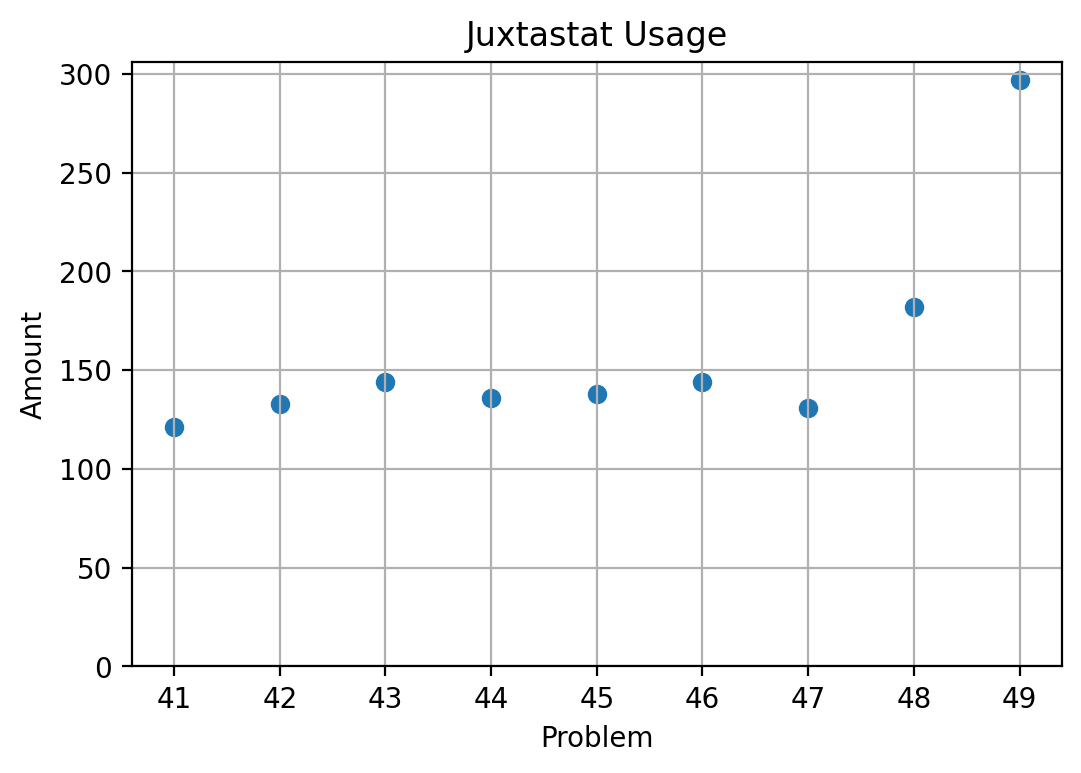

In [6]:
plt.figure(dpi=200)
plt.title("Juxtastat Usage")
plt.scatter(num_users_by_problem.index, num_users_by_problem)
plt.xlabel("Problem")
plt.ylabel("Amount")
plt.ylim(0, plt.ylim()[1])
plt.grid()

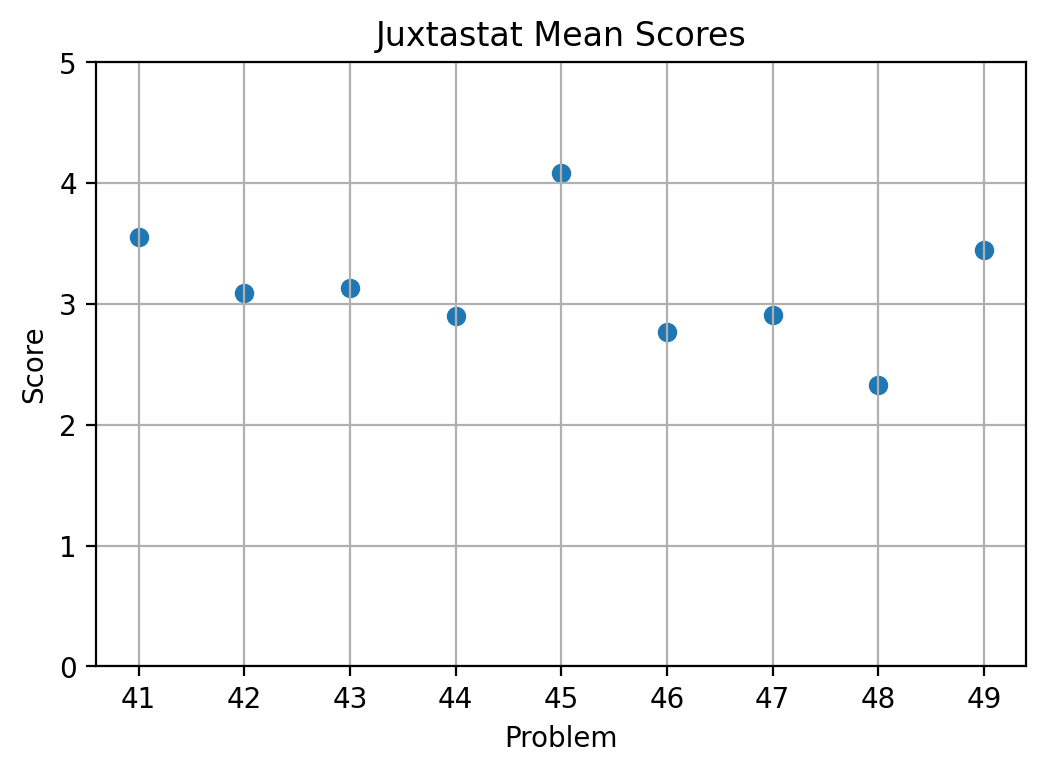

In [7]:
plt.figure(dpi=200)
plt.title("Juxtastat Mean Scores")
plt.scatter(means.index, means.score)
plt.ylim(0, 5)
plt.xlabel("Problem")
plt.ylabel("Score")
plt.grid()

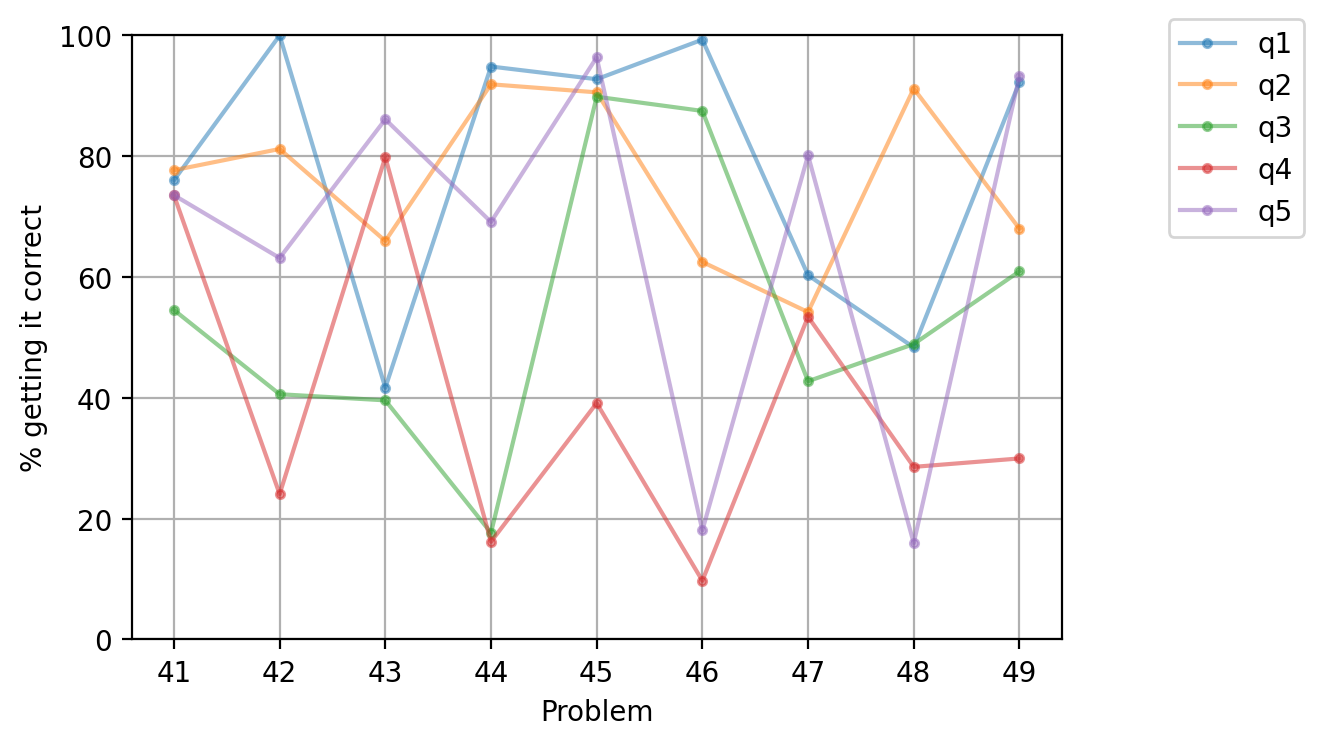

In [8]:
plt.figure(dpi=200)
for q in questions:
    plt.plot(means.index, 100 * means[q], label=q, marker=".", alpha=0.5)
plt.ylim(0, 100)
plt.xlabel("Problem")
plt.ylabel("% getting it correct")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()